In [69]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

In [70]:
import matplotlib.pyplot as plt
import torch

In [71]:
import bnn.functions
import bnn.loss
import bnn.network

In [72]:
dims = [32]*5 + [64]*10 + [128]*10 + [64]*10 + [32]*5
dims = [d*2 for d in dims]
TBNN = bnn.network.TernBinNetwork(*dims, bit_shift=3)

In [73]:
samples = 1

input = bnn.functions.binarise.apply(torch.randn(samples, dims[0]))
desired = bnn.functions.binarise.apply(torch.randn(samples, dims[-1]))

In [74]:
TBNN.zero_grad()
output = TBNN(input)
loss = bnn.loss.number_incorrect(output=output, label=desired)
loss.backward()

In [75]:
vars = [] 
grad_vars = []

for layer in TBNN.layers.values():
    vars.append(layer.W.var().detach())
    grad_vars.append(layer.W.grad.var().detach())

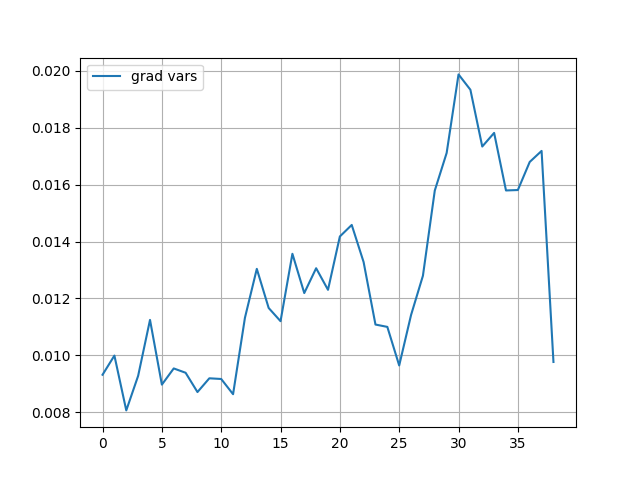

In [76]:
plt.close()
#plt.plot(vars, label="vars")
plt.plot(grad_vars, label="grad vars")
plt.legend()
plt.grid()
plt.show()

In [78]:
for p in TBNN.named_parameters():
    print(p)

('layers.TernBinLayer0.W', Parameter containing:
tensor([[-1., -1., -1.,  ...,  1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1.,  1.],
        [ 1.,  1., -1.,  ...,  1., -1.,  1.],
        ...,
        [ 1.,  1., -1.,  ..., -1., -1.,  1.],
        [ 1., -1., -1.,  ...,  1.,  1., -1.],
        [ 1.,  1., -1.,  ...,  1.,  1., -1.]], requires_grad=True))
('layers.TernBinLayer1.W', Parameter containing:
tensor([[ 1., -1.,  1.,  ...,  1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [ 1., -1., -1.,  ...,  1., -1.,  1.],
        ...,
        [-1., -1.,  1.,  ..., -1.,  1., -1.],
        [-1., -1., -1.,  ..., -1., -1.,  1.],
        [-1.,  1.,  1.,  ...,  1., -1., -1.]], requires_grad=True))
('layers.TernBinLayer2.W', Parameter containing:
tensor([[ 1., -1., -1.,  ...,  1.,  1.,  1.],
        [ 1., -1.,  1.,  ...,  1., -1., -1.],
        [-1.,  1., -1.,  ...,  1.,  1.,  1.],
        ...,
        [-1.,  1., -1.,  ..., -1., -1.,  1.],
        [ 1.,  1., -1.,  ...,  1.,